In [29]:
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn, config_context
patch_sklearn()
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [30]:
import os
ipynb_path = os.getcwd()
src_path = os.path.join(ipynb_path, 'src/')
input_path = os.path.join(ipynb_path,"input/")

In [31]:

import warnings
import os
import sys

import scipy.stats as spst

sys.path.append(src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
from windpowerlib.wind_speed import logarithmic_profile
from src.utils import uv_to_wsd # 윈도우에서는 앞에 src를 뺄것

In [32]:
power_2020 = pd.read_parquet(input_path + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}, axis=1)[:-3]
power_2021 = pd.read_parquet(input_path + "dynamic_report_ewp02_2021_10min.parquet").rename({'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}, axis=1)[:-3]
power_2022 = pd.read_parquet(input_path + "dynamic_report_ewp02_2022_10min.parquet").rename({'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}, axis=1)[:-3]
power = pd.concat([power_2020, power_2021, power_2022], ignore_index=True)

gj_y = pd.read_parquet(input_path + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(input_path + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (155528, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# yongmin's functions
from src.utils import DataConnector
from src.metric import NMAE
from src.data_processor import *

# model import
import xgboost as xgb
from xgboost import XGBRegressor


In [34]:
# 파이프라인 구성 및 적용
DataPipeline = Pipeline([
    ('uv_transform', UVTransformer('wind_u_10m', 'wind_v_10m')),
    ('wind_transform', WindTransformer('wind_speed', 10, 100, ldaps['surf_rough'].mean())),
    ('feature_engineering', FeatureTransformer()),
])

# 파이프라인을 이용하여 ldaps 데이터 변환
ldaps_transformed = DataPipeline.fit_transform(ldaps)

print(ldaps_transformed.shape)


(235818, 23)


In [35]:
average_ldaps = ldaps_transformed.drop('turbine_id', axis=1).groupby('dt').mean()
average_ldaps.columns = average_ldaps.columns.str.replace(r'[<>\[\]]', '_', regex=True)
average_ldaps.columns = average_ldaps.columns.str.replace(r'[^\w]', '_', regex=True)
average_ldaps.columns = average_ldaps.columns.str.replace(r'__+', '_', regex=True)

In [36]:
average_ldaps.reset_index(inplace=True)


In [37]:
average_ldaps['dt'] = pd.to_datetime(average_ldaps['dt']).dt.tz_localize(None)
gj_y['dt'] = pd.to_datetime(gj_y['dt']).dt.tz_localize(None)
avg_data = pd.merge(average_ldaps, gj_y, on='dt', how='inner')

In [38]:
avg_data_sorted = avg_data.sort_values(['dt', 'plant_name', 'energy_kwh'], ascending=[True, True, False])
avg_data_cleaned = avg_data_sorted.drop_duplicates(subset=['dt', 'plant_name'], keep='first')

In [39]:
avg_data_cleaned = avg_data.drop_duplicates(subset=['dt'], keep='first')
avg_data = avg_data_cleaned

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def get_trasforms_datas(merged_data, numeric_columns, target):
    z_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()
    
    x_train = merged_data.loc[merged_data['dt'].between('2020-01-01', '2020-12-31', inclusive='left'), numeric_columns]
    x_test = merged_data.loc[merged_data['dt'].between('2021-01-01', '2022-12-31', inclusive='left'), numeric_columns]

    y_train = merged_data.loc[merged_data['dt'].between('2020-01-01', '2020-12-31', inclusive='left'), target]
    y_test = merged_data.loc[merged_data['dt'].between('2021-01-01', '2022-12-31', inclusive='left'), target]
    #y_train = y_train.dropna()
    #y_test = y_test.dropna()

    # Min-Max Scaling
    x_train_m = minmax_scaler.fit_transform(x_train)
    x_train_m = pd.DataFrame(x_train_m, columns=x_train.columns)
    x_test_m = minmax_scaler.transform(x_test)
    x_test_m = pd.DataFrame(x_test_m, columns=x_train.columns)

    # Standard Scaling
    x_train_z = z_scaler.fit_transform(x_train)
    x_train_z = pd.DataFrame(x_train_z, columns=x_train.columns)
    x_test_z = z_scaler.transform(x_test)
    x_test_z = pd.DataFrame(x_test_z, columns=x_train.columns)

    return x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test

In [41]:
from sklearn.cluster import KMeans

# 이제 특징 생성에 클러스터링 결과는 보지 않을 예정.
def addKmeansFeature(train_data, test_data):
    pd.options.mode.chained_assignment = None

    for n_clusters in range(2, 7):  # 2부터 6까지 클러스터 생성
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)

        train_data[f'cluster_{n_clusters}'] = kmeans.fit_predict(train_data[['wind_speed', 'wind_direction']])
        
        test_data[f'cluster_{n_clusters}'] = kmeans.predict(test_data[['wind_speed', 'wind_direction']])

    return train_data, test_data
from sklearn.decomposition import PCA

def addPCAFeature(train_data, test_data):
    # PCA 적용할 특징 열 선택 (u, v 성분)
    wind_features = ['storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m', 
                     'wind_speed', 'wind_direction']
    
    # 훈련 데이터에서 PCA 학습
    pca = PCA(n_components=2)
    pca_train = pca.fit_transform(train_data[wind_features])
    
    # 훈련 데이터에 주성분 추가
    train_data['PC1'] = pca_train[:, 0]
    train_data['PC2'] = pca_train[:, 1]
    
    # 테스트 데이터에 PCA 적용
    pca_test = pca.transform(test_data[wind_features])
    test_data['PC1'] = pca_test[:, 0]
    test_data['PC2'] = pca_test[:, 1]

    # PCA 설명력 확인
    explained_variance = pca.explained_variance_ratio_
    print(f"PC1 설명력: {explained_variance[0]}")
    print(f"PC2 설명력: {explained_variance[1]}")

    return train_data, test_data

from sklearn_extra.cluster import KMedoids

def addKMedoidsFeature(train_data, test_data):
    pd.options.mode.chained_assignment = None

    for n_clusters in range(2, 7):  # 2부터 6까지 클러스터 생성
        kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)

        # 훈련 데이터에 K-Medoids 클러스터링 적용
        train_data[f'medoid_cluster_{n_clusters}'] = kmedoids.fit_predict(train_data[['wind_speed', 'wind_direction']])

        # 테스트 데이터에 학습된 K-Medoids 모델 적용
        test_data[f'medoid_cluster_{n_clusters}'] = kmedoids.predict(test_data[['wind_speed', 'wind_direction']])

    return train_data, test_data


In [42]:
numeric_columns = avg_data.select_dtypes(include=['number']).columns.tolist()

In [43]:
x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test = get_trasforms_datas(avg_data, numeric_columns, 'energy_kwh')

In [44]:
x_train, x_test = addKmeansFeature(x_train, x_test)
x_train_m, x_test_m = addKmeansFeature(x_train_m, x_test_m)
x_train_z, x_test_z = addKmeansFeature(x_train_z, x_test_z)
print('kmean 적용 완료')
x_train, x_test = addPCAFeature(x_train, x_test)
x_train_m, x_test_m = addPCAFeature(x_train_m, x_test_m)
x_train_z, x_test_z = addPCAFeature(x_train_z, x_test_z)
print('pca 적용 완료')

x_train, x_test = addKMedoidsFeature(x_train, x_test)
x_train_m, x_test_m = addKMedoidsFeature(x_train_m, x_test_m)
x_train_z, x_test_z = addKMedoidsFeature(x_train_z, x_test_z)
print('kmedoid 적용 완료')


kmean 적용 완료
PC1 설명력: 0.9982665777206421
PC2 설명력: 0.000830549921374768
PC1 설명력: 0.7499995755457655
PC2 설명력: 0.11854411387391413
PC1 설명력: 0.33917607071751443
PC2 설명력: 0.32569090287750574
pca 적용 완료
kmedoid 적용 완료


In [45]:
x_dict = {
    # 원본 데이터만 사용
    'original': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                 'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                 'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m'],

    # PCA 추가
    'pca_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                 'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                 'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'PC1', 'PC2'],

    # 클러스터(2~6) 추가
    'cluster_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                     'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                     'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 
                     'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'],

    # PCA + 클러스터(2~6) 추가
    'pca_and_cluster': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                        'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                        'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 
                        'PC1', 'PC2', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'],

    # 클러스터 개수에 따른 경우
    'cluster_2_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                       'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                       'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'cluster_2'],
    
    'cluster_3_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                       'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                       'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'cluster_3'],
    
    'cluster_4_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                       'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                       'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'cluster_4'],
    
    'cluster_5_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                       'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                       'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'cluster_5'],
    
    'cluster_6_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                       'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                       'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'cluster_6'],

    # KMedoids 추가
    'kmedoids_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                      'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                      'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 
                      'medoid_cluster_2', 'medoid_cluster_3', 'medoid_cluster_4', 'medoid_cluster_5', 'medoid_cluster_6'],

    # PCA + KMedoids 추가
    'pca_and_kmedoids': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                         'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                         'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 
                         'PC1', 'PC2', 'medoid_cluster_2', 'medoid_cluster_3', 'medoid_cluster_4', 'medoid_cluster_5', 'medoid_cluster_6'],

    # KMedoids 클러스터 개수에 따른 경우
    'medoid_cluster_2_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                              'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                              'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'medoid_cluster_2'],

    'medoid_cluster_3_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                              'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                              'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'medoid_cluster_3'],

    'medoid_cluster_4_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                              'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                              'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'medoid_cluster_4'],

    'medoid_cluster_5_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                              'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                              'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'medoid_cluster_5'],

    'medoid_cluster_6_only': ['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m', 'frictional_vmin_50m', 
                              'pressure', 'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m', 'storm_v_5m', 
                              'wind_u_10m', 'wind_v_10m', 'wind_speed', 'wind_direction', 'wind_speed_100m', 'medoid_cluster_6']

}


In [46]:
import torch

In [47]:
from src.deepTrain_roughVer.Analysis_WindTurbine.Model.RNNs import RNN,LSTM,GRU

In [48]:
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim

In [49]:
# ㅇmake window
def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len + 1):
        seq = data[i:i+seq_len]
        sequences.append(seq)
    return torch.tensor(sequences, dtype=torch.float32)


In [50]:
from sklearn.metrics import r2_score, mean_absolute_error

def NMAE(y_true, y_pred):
    """NMAE 계산 함수."""
    return mean_absolute_error(y_true, y_pred) / (sum(abs(y_true)) / len(y_true)) * 100

# general model test batch : test 30
# decomp model test batch : 16
# need test 24,28
def train_model(save_dir, model, x_train, y_train, x_test, y_test, epochs=200, batch_size=24, lr=0.001, criterion_type = 'MSE', early_n=None):
    if not torch.cuda.is_available():
        raise RuntimeError("cuda is not available. exiting...")

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    model = model.cuda()

    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32).cuda()
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).cuda()
    #print(x_train_tensor.shape)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).cuda()
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).cuda()

    # data loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # set
    if criterion_type == 'MSE':
        criterion = nn.MSELoss()
    else:
        criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # losses
    best_val_loss = float('inf')
    best_y_pred_list = []
    best_y_true_list = []
    train_losses = []
    val_losses = []
    early_stop_counter = 0

    csv_data = []

    # train
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            #print(inputs.shape)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        y_pred_list = []
        y_true_list = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.cuda(), targets.cuda()
                
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
                y_pred_list.extend(outputs.cpu().numpy())
                y_true_list.extend(targets.cpu().numpy())

        y_pred_list = np.array(y_pred_list).flatten()
        y_true_list = np.array(y_true_list).flatten()

        mae = mean_absolute_error(y_true_list, y_pred_list)
        nmae = NMAE(y_true_list, y_pred_list)
        r2 = r2_score(y_true_list, y_pred_list)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))

        csv_data.append([epoch + 1, train_loss / len(train_loader), val_loss / len(test_loader), mae, nmae, r2])

        # overfiting 방지
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_y_pred_list = y_pred_list
            best_y_true_list = y_true_list
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, f"{model.__class__.__name__}_best_model.pth"))
            early_stop_counter = 0  # Reset early stopping counter
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(test_loader):.4f}, MAE: {mae:.4f}, NMAE: {nmae:.4f}, R^2: {r2:.4f}")

        # Early stopping
        if early_n is not None and early_stop_counter >= early_n:
            print(f"early stopping at epoch {epoch+1}. Best epoch: {best_epoch} with val Loss: {best_val_loss:.4f}")
            break

    df = pd.DataFrame(csv_data, columns=["Epoch", "Train Loss", "Val Loss", "MAE", "NMAE", "R2"])
    df.to_csv(os.path.join(save_dir, "training_log.csv"), index=False)

    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
    plt.plot(range(len(val_losses)), val_losses, label="Val Loss")
    #plt.scatter(best_epoch - 1, best_val_loss, color="red", label=f"Best Val Loss: {best_val_loss:.4f}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss plot (Best Val Loss at epoch {best_epoch}: {(best_val_loss/1000):.2f}k)")
    plt.savefig(os.path.join(save_dir, "loss_plot.png"))
    plt.close()

    plt.figure()
    plt.plot(best_y_true_list, label="ground truth")
    plt.plot(best_y_pred_list, label="Pred")
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.legend()
    plt.title("Pred and Truth Compare")
    plt.savefig(os.path.join(save_dir, "best_pred_plot.png"))
    plt.close()

    with open(os.path.join(save_dir, "training_log.txt"), "w") as f:
        f.write(f"Final Validation Loss: {best_val_loss:.4f}\n")
        f.write(f"MAE: {mae:.4f}, NMAE: {nmae:.4f}, R^2: {r2:.4f}\n")
        f.write(f"devide capacity => MAE/20700: {(mae/20700):.4f}, MAE/79600: {(mae/79600):.4f}")

    print(f"Final Model saved with best validation loss: {best_val_loss:.4f}")
    print(f"MAE: {mae:.4f}, NMAE: {nmae:.4f}, R^2: {r2:.4f}")

In [51]:
#for key in x_dict.keys():
#    # ====================
#    # Min-Max 정규화 데이터
#    # ====================
#    x_train_m_selected = x_train_m[x_dict[key]]
#    x_test_m_selected = x_test_m[x_dict[key]]

##    # RNN 모델 학습
##    rnn_model = RNN(input_dim=x_train_m_selected.shape[1], hidden_dim=128)
##    save_dir = os.path.join(ipynb_path, f'notebooks/test_basicRecurrent/{key}_RNN_m/')
##    train_model(save_dir, rnn_model, x_train_m_selected, y_train, x_test_m_selected, y_test,1500)

#    # LSTM 모델 학습
#    lstm_model = LSTM(input_dim=x_train_m_selected.shape[1], hidden_dim=128, bidirectional=True)
#    save_dir = os.path.join(ipynb_path, f'notebooks/test_bidirectional_lstm/{key}_LSTM_m/')
#    train_model(save_dir, lstm_model, x_train_m_selected, y_train, x_test_m_selected, y_test,1500)

##    # GRU 모델 학습
##    gru_model = GRU(input_dim=x_train_m_selected.shape[1], hidden_dim=128)
##    save_dir = os.path.join(ipynb_path, f'notebooks/test_basicRecurrent/{key}_GRU_m/')
##    train_model(save_dir, gru_model, x_train_m_selected, y_train, x_test_m_selected, y_test,1500)

##    # ====================
##    # z-정규화 데이터
##    # ====================
#    x_train_z_selected = x_train_z[x_dict[key]]
#    x_test_z_selected = x_test_z[x_dict[key]]

##    # RNN 모델 학습
##    rnn_model = RNN(input_dim=x_train_z_selected.shape[1], hidden_dim=128)
##    save_dir = os.path.join(ipynb_path, f'notebooks/test_basicRecurrent/{key}_RNN_z/')
##    train_model(save_dir, rnn_model, x_train_z_selected, y_train, x_test_z_selected, y_test,1500)

#    # LSTM 모델 학습
#    lstm_model = LSTM(input_dim=x_train_z_selected.shape[1], hidden_dim=128)
#    save_dir = os.path.join(ipynb_path, f'notebooks/test_bidirectional_lstm/{key}_LSTM_z/')
#    train_model(save_dir, lstm_model, x_train_z_selected, y_train, x_test_z_selected, y_test,1500)

##    # GRU 모델 학습
##    gru_model = GRU(input_dim=x_train_z_selected.shape[1], hidden_dim=128)
##    save_dir = os.path.join(ipynb_path, f'notebooks/test_basicRecurrent/{key}_GRU_z/')
##    train_model(save_dir, gru_model, x_train_z_selected, y_train, x_test_z_selected, y_test,1500)


In [52]:
# 가망 없을 것 같아서 임의로 학습 중단함. 모든 val_los가 1500에폭 기준 3 * 1e7 근처를 돌고 있음. 
# 그나마 GRU마서 하하 더 더리면 될거 거긴 한데, model 다시짜는게 better

In [53]:
from src.deepTrain_roughVer.Analysis_WindTurbine.Model.RNNs import LSTM, GRU

In [61]:
class LSTMModule(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, rec_dropout=0.4, num_layers=1, bidirectional=False):
        super(LSTMModule, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, bidirectional=bidirectional, batch_first=True,
                           dropout=rec_dropout, num_layers=num_layers)

    def save(self, filename):
        torch.save(self.state_dict(), filename)

    def load(self, filename=None, parameters=None):
        if filename is not None:
            self.load_state_dict(torch.load(filename))
        elif parameters is not None:
            self.load_state_dict(parameters)
        else:
            raise NotImplementedError("load is a filename or a list of parameters (state_dict)")

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return recurrent

class GRUModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, rec_dropout=0.4, num_layers=1, bidirectional=False):
        super(GRUModule, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, bidirectional=bidirectional, batch_first=True,
                          dropout=rec_dropout, num_layers=num_layers)

    def save(self, filename):
        torch.save(self.state_dict(), filename)

    def load(self, filename=None, parameters=None):
        if filename is not None:
            self.load_state_dict(torch.load(filename))
        elif parameters is not None:
            self.load_state_dict(parameters)
        else:
            raise NotImplementedError("load is a filename or a list of parameters (state_dict)")

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return recurrent

# Models
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, rec_dropout=0.4, num_layers=1, bidirectional=False):
        super(RNN, self).__init__()
        self.rnn_module = RNNModule(input_dim, hidden_dim, rec_dropout, num_layers, bidirectional)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim/2)
        self.fc2 = nn.Linear(hidden_dim/2, 1)

    def forward(self, x):
        recurrent = self.rnn_module(x)
        out = self.fc1(recurrent)
        out = self.fc2(out)
        return out

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, rec_dropout=0.4, num_layers=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.lstm_module = LSTMModule(input_dim, hidden_dim, rec_dropout, num_layers, bidirectional)
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.fc1 = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU()
            )
        else:
            self.fc1 = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU()
            )
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        recurrent = self.lstm_module(x)
        out = self.fc1(recurrent)
        out = self.fc2(out)
        # out = torch.clamp(out, min=0) # capacity write later
        return out


class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, rec_dropout=0.4, num_layers=1, bidirectional=False):
        super(GRU, self).__init__()
        self.gru_module = GRUModule(input_dim, hidden_dim, rec_dropout, num_layers, bidirectional)
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.fc1 = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU()
            )
        else:
            self.fc1 = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU()
            )
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        recurrent = self.gru_module(x)
        out = self.fc1(recurrent)
        out = self.fc2(out)
        # out = torch.clamp(out, min=0) # capacity write later
        return out


In [60]:
# bidirectional

for key in x_dict.keys():
    if key == 'original':
        continue

    # ====================
    # z-정규화 데이터
    # ====================
    x_train_z_selected = x_train_z[x_dict[key]]
    x_test_z_selected = x_test_z[x_dict[key]]

    print(x_train_z_selected.columns)

    # LSTM 모델 학습
    #lstm_model = LSTM(input_dim=x_test_z_selected.shape[1], hidden_dim=400,num_layers=4, bidirectional=True)
    #save_dir = os.path.join(ipynb_path, f'notebooks/yg/TEST_bidirectional_smoothL1_useRelu400/{key}_LSTM256_3_z/')
    #train_model(save_dir, lstm_model, x_train_z_selected, y_train, x_test_z_selected, y_test,1500, criterion_type='SmoothL1')

    # GRU 모델 학습
    lstm_model = GRU(input_dim=x_test_z_selected.shape[1], hidden_dim=256,num_layers=4, bidirectional=True)
    save_dir = os.path.join(ipynb_path, f'notebooks/gj/TEST_bidirectional_smoothL1_useRelu/{key}_GRU256_3_z/')
    train_model(save_dir, lstm_model, x_train_z_selected, y_train, x_test_z_selected, y_test,1500, criterion_type='SmoothL1')


Index(['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m',
       'frictional_vmin_50m', 'pressure', 'relative_humid', 'specific_humid',
       'temp_air', 'storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m',
       'wind_speed', 'wind_direction', 'wind_speed_100m', 'PC1', 'PC2'],
      dtype='object')
Epoch [1/1500]
Train Loss: 5754.4059
Val Loss: 5130.2002, MAE: 5130.6997, NMAE: 78.1064, R^2: -0.0118
Epoch [2/1500]
Train Loss: 5230.3606
Val Loss: 5142.5701, MAE: 5143.0698, NMAE: 78.2948, R^2: -0.0092
Epoch [3/1500]
Train Loss: 5231.6014
Val Loss: 5135.6958, MAE: 5136.1958, NMAE: 78.1901, R^2: -0.0105
Epoch [4/1500]
Train Loss: 5231.3903
Val Loss: 5131.6178, MAE: 5132.1177, NMAE: 78.1280, R^2: -0.0114
Epoch [5/1500]
Train Loss: 5231.7403
Val Loss: 5129.6307, MAE: 5130.1304, NMAE: 78.0978, R^2: -0.0119
Epoch [6/1500]
Train Loss: 5232.2669
Val Loss: 5128.6706, MAE: 5129.1704, NMAE: 78.0832, R^2: -0.0121
Epoch [7/1500]
Train Loss: 5232.7087
Val Loss: 5127.5793, MAE: 5128.0

KeyboardInterrupt: 

In [ ]:
#i'm not sure if this is right. 
#it just average convergence.
#i think it's better to throw it away and start from scratch.

In [ ]:
# 영광 loading

In [34]:
# train

| model_name                        | min_val_loss | MAE       | gj_NMAE   | yg_NMAE   | criterion |
|------------------------------------|--------------|-----------|-----------|-----------|-----------|
| pca_and_cluster_GRU256_3_z         | 2878.514595  | 2879.0142 | 0.139083  | 0.036169  | SmoothL1  |
| cluster_6_only_GRU256_3_z          | 2881.707765  | 2882.2078 | 0.139237  | 0.036209  | SmoothL1  |
| medoid_cluster_3_only_GRU256_3_z   | 2892.986949  | 2893.4868 | 0.139782  | 0.036350  | SmoothL1  |
| medoid_cluster_2_only_GRU256_3_z   | 2893.539833  | 2894.0398 | 0.139809  | 0.036357  | SmoothL1  |
| cluster_only_GRU256_3_z            | 2899.382190  | 2899.8820 | 0.140091  | 0.036431  | SmoothL1  |
| medoid_cluster_5_only_GRU256_3_z   | 2904.483284  | 2904.9832 | 0.140337  | 0.036495  | SmoothL1  |
| kmedoids_only_GRU256_3_z           | 2904.883852  | 2905.3838 | 0.140357  | 0.036500  | SmoothL1  |

- train this seven models.

In [64]:
yg_y = pd.read_parquet(input_path + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(input_path + "train_ldaps_yeonggwang.parquet")

print("train_y: ", yg_y.shape)
print("LDAPS: ", ldaps.shape)

train_y:  (52608, 4)
LDAPS:  (917070, 15)


In [ ]:
# 파이프라인 구성 및 적용
DataPipeline = Pipeline([
    ('uv_transform', UVTransformer('wind_u_10m', 'wind_v_10m')),
    ('wind_transform', WindTransformer('wind_speed', 10, 100, ldaps['surf_rough'].mean())),
    ('feature_engineering', FeatureTransformer()),
])

# 파이프라인을 이용하여 ldaps 데이터 변환
ldaps_transformed = DataPipeline.fit_transform(ldaps)

print(ldaps_transformed.shape)


average_ldaps = ldaps_transformed.drop('turbine_id', axis=1).groupby('dt').mean()
average_ldaps.columns = average_ldaps.columns.str.replace(r'[<>\[\]]', '_', regex=True)
average_ldaps.columns = average_ldaps.columns.str.replace(r'[^\w]', '_', regex=True)
average_ldaps.columns = average_ldaps.columns.str.replace(r'__+', '_', regex=True)

average_ldaps.reset_index(inplace=True)


average_ldaps['dt'] = pd.to_datetime(average_ldaps['dt']).dt.tz_localize(None)
yg_y = yg_y.loc[yg_y['plant_name'] == '영광풍력']
#yg_y.head()
yg_y['dt'] = pd.to_datetime(yg_y['dt']).dt.tz_localize(None)
avg_data = pd.merge(average_ldaps, yg_y, on='dt', how='inner')

In [67]:
avg_data_sorted = avg_data.sort_values(['dt', 'plant_name', 'energy_kwh'], ascending=[True, True, False])
avg_data_cleaned = avg_data_sorted.drop_duplicates(subset=['dt', 'plant_name'], keep='first')

avg_data_cleaned = avg_data.drop_duplicates(subset=['dt'], keep='first')
avg_data = avg_data_cleaned
numeric_columns = avg_data.select_dtypes(include=['number']).columns.tolist()
x_train, x_test, x_train_m, x_test_m, x_train_z, x_test_z, y_train, y_test = get_trasforms_datas(avg_data, numeric_columns, 'energy_kwh')

In [68]:
x_train, x_test = addKmeansFeature(x_train, x_test)
x_train_m, x_test_m = addKmeansFeature(x_train_m, x_test_m)
x_train_z, x_test_z = addKmeansFeature(x_train_z, x_test_z)
print('kmean 적용 완료')
x_train, x_test = addPCAFeature(x_train, x_test)
x_train_m, x_test_m = addPCAFeature(x_train_m, x_test_m)
x_train_z, x_test_z = addPCAFeature(x_train_z, x_test_z)
print('pca 적용 완료')

x_train, x_test = addKMedoidsFeature(x_train, x_test)
x_train_m, x_test_m = addKMedoidsFeature(x_train_m, x_test_m)
x_train_z, x_test_z = addKMedoidsFeature(x_train_z, x_test_z)
print('kmedoid 적용 완료')

kmean 적용 완료
PC1 설명력: 0.9969626069068909
PC2 설명력: 0.001954863080754876
PC1 설명력: 0.7320484617797179
PC2 설명력: 0.14104104431898426
PC1 설명력: 0.46370585375874857
PC2 설명력: 0.23818530022354453
pca 적용 완료
kmedoid 적용 완료


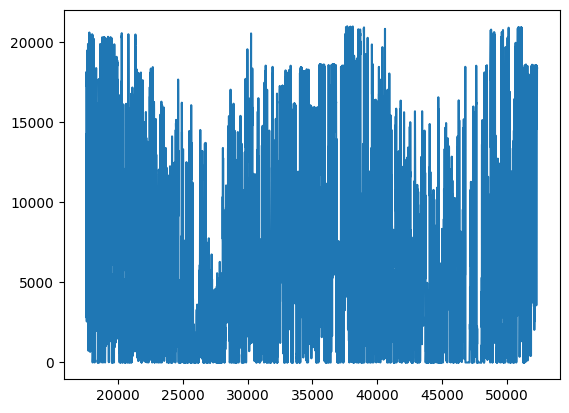

In [70]:
plt.plot(y_test)

In [ ]:
# bidirectional
include_key = [
    'pca_and_cluster',
    'cluster_6',
    'medoid_cluster_3',
    'medoid_cluster_2',
    'cluster_only',
    'medoid_cluster_5',
    'kmedoids_only',
]

for key in x_dict.keys():
    if key is not 'pca_and_cluster':
        continue
    print(key)
    # ====================
    # z-정규화 데이터
    # ====================
    x_train_z_selected = x_train_z[x_dict[key]]
    x_test_z_selected = x_test_z[x_dict[key]]

    print(x_train_z_selected.columns)

    # GRU 모델 학습
    lstm_model = GRU(input_dim=x_test_z_selected.shape[1], hidden_dim=256,num_layers=4, bidirectional=True)
    save_dir = os.path.join(ipynb_path, f'notebooks/yg/TEST_bidirectional_smoothL1_useRelu400/{key}_GRU256_3_z/')
    train_model(save_dir, lstm_model, x_train_z_selected, y_train, x_test_z_selected, y_test,1500, criterion_type='SmoothL1')


cluster_only
Index(['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m',
       'frictional_vmin_50m', 'pressure', 'relative_humid', 'specific_humid',
       'temp_air', 'storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m',
       'wind_speed', 'wind_direction', 'wind_speed_100m', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6'],
      dtype='object')
Epoch [1/1500]
Train Loss: 5770.0102
Val Loss: 5115.6329, MAE: 5116.1328, NMAE: 77.8847, R^2: -0.0160
Epoch [2/1500]
Train Loss: 5230.8074
Val Loss: 5135.0330, MAE: 5135.5327, NMAE: 78.1800, R^2: -0.0106
Epoch [3/1500]
Train Loss: 5233.2539
Val Loss: 5125.7573, MAE: 5126.2573, NMAE: 78.0388, R^2: -0.0129
Epoch [4/1500]
Train Loss: 5234.0504
Val Loss: 5122.2629, MAE: 5122.7627, NMAE: 77.9856, R^2: -0.0139
Epoch [5/1500]
Train Loss: 5234.0325
Val Loss: 5122.0477, MAE: 5122.5474, NMAE: 77.9823, R^2: -0.0139
Epoch [6/1500]
Train Loss: 5233.8025
Val Loss: 5121.2221, MAE: 5121.7222, NMAE: 77.9698, R^2: -0.014